# The data
This notebook aims at presenting the process of creating the end-to-end modelling pipeline with the use of [PyPlatypus](https://github.com/maju116/pyplatypus) package.

As starting point, the data is crucial, let's proceed with gathering it hence. We will be working with the nuclei-related images of which the [2018 Data Science Bowl dataset](https://www.kaggle.com/c/data-science-bowl-2018/data) is composed. These are PNG files organized in accordance with the following structure:

stage1_data

----|image_name

--------|images

------------|image.png

--------|masks

------------|mask1.png

------------|mask2.png

In the "images" folder you will find an PNG image of shape (256, 256, 3) - RGB - with the values varying from 0 to 255, while the masks are just (256, 256, 3) images with the values coming from the discrete set: {[0, 0, 0], [255, 255, 255]} - colormap needed to assign pixel to a specific class. In our case it will be binary semantic segmentation.

Note that [PyPlatypus](https://github.com/maju116/pyplatypus) can work with multiple images and masks per sample of type PNG, JPG, JPEG, DICOM and TIFF. To see mre examples vivit [PyPlatypus website](https://maju116.github.io/pyplatypus/)

# The preparation
After downloading the data, unpack it and move to any preferred destination. For this example we will be interested only in stage1_train and stage1_test subdirectories, thus other files could be put aside. Let's take a look at the exemplary image.

In [ ]:
! pip install pyplatypus

In [1]:
from pathlib import Path
import os
cwd = Path.cwd()
while cwd.stem != "pyplatypus":
    cwd = cwd.parent
os.chdir(cwd)

In [29]:
import numpy as np
from random import sample
from PIL import Image

# Handy functions for plotting this example's data.
def prepare_masks(masks: list, np_original_size: np.array, masks_frame: np.array):
    for mask in masks:
        loaded_mask_ = plt.imread(mask)
        if loaded_mask_.shape != np_original_size:
            rotated_loaded_mask_ = np.rot90(loaded_mask_)
            masks_frame += rotated_loaded_mask_
        else:
            masks_frame += loaded_mask_
    return masks_frame


def sample_and_plot_predictions(data_path: Path, model_name: str, n=3):
    validation_images = glob(str(data_path/Path("stage1_validation/*")))
    # Sample size
    n_max = len(validation_images)
    n = n_max if n > n_max else n
    validation_images = sample(validation_images, n)
    for img_path in validation_images:
        img_name = img_path.split("/")[-1:][0]
        img = glob(f"{img_path}/images/*.png")[0]
        predictions = glob(f"{img_path}/predicted_masks/{img_name}_{model_name}_predicted_mask.png")[0]
        masks = glob(f"{img_path}/masks/*.png")
        # Load images
        img_loaded = Image.open(img)
        original_size = img_loaded.size
        np_original_size = tuple(reversed(original_size))
        # Load masks and squeeze them into one frame
        masks_frame = np.zeros(np_original_size)
        masks_frame = prepare_masks(masks, np_original_size, masks_frame)
        # Load predictions
        predictions_loaded = Image.open(predictions)
        original_size_scaled = (np.array(original_size)/2).astype(int)
        predictions_scaled = predictions_loaded.resize(original_size_scaled)
        # Plot image alongside true and predicted masks
        f, axarr = plt.subplots(1, 3)
        plt.title(f"Image and predictions: {img_name}")
        axarr[0].imshow(img_loaded)
        axarr[0].set_title("Original image")
        axarr[1].imshow(masks_frame)
        axarr[1].set_title("True masks")
        axarr[2].imshow(predictions_scaled)
        axarr[2].set_title("Predicted masks")

In [3]:
# 20% for validation
data_path = Path("examples/data/data_science_bowl/")
models_path = Path("examples/models/")

example = "0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9"
train_image = os.listdir(data_path/Path(f"stage1_train/{example}/images"), )
train_masks = os.listdir(data_path/Path(f"stage1_train/{example}/masks"))

In [4]:
from matplotlib import pyplot as plt
# Load the image along with on of the masks associated
example_image = plt.imread(data_path/Path(f"stage1_train/{example}/images/{train_image[0]}"))
example_mask1 = plt.imread(data_path/Path(f"stage1_train/{example}/masks/{train_masks[0]}"))
example_mask2 = plt.imread(data_path/Path(f"stage1_train/{example}/masks/{train_masks[2]}"))

Text(0.5, 1.0, 'Original image with the masks in yellow.')

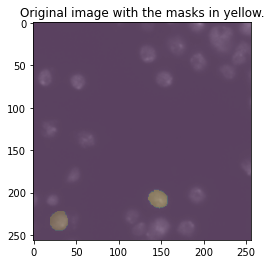

In [5]:
plt.figure()
plt.imshow(example_image, alpha=0.6)
plt.imshow(example_mask1, alpha=0.2)
plt.imshow(example_mask2, alpha=0.2)
plt.title("Original image with the masks in yellow.")

What you see as the yellow area is the "Segmentation mask" which is simply telling us which pixel belongs to which class. Assesing this membership is the goal that we are striving to achieve.

# Splitting the data
For the modeling, beside train and test sets, we will need a validation set for it is common good practice to have one.
Feel free to use the following script but beware, it will move a sample set of images from yout stage1_train folder to the stage1_validation.

In [ ]:
from glob import glob
from random import sample
from shutil import move

def create_validation_set(data_path, p=0.2):
    train_images = glob(str(data_path/Path("stage1_train/*")))
    # Validation set size (as percentage)
    p = 0.2
    validation_images = sample(train_images, round(p*len(train_images)))
    Path.mkdir(data_path/Path("stage1_validation"))
    for img_path in validation_images:
        trimmed_path = Path(img_path).stem
        move(img_path, str(data_path/Path(f"stage1_validation/{trimmed_path}")))

Let's now inspect the input message that we are to send to PlatypusSolver in order to run it.

In [7]:
import yaml
import json
with open(r"examples/data_science_bowl_config.yaml") as stream:
    config = yaml.safe_load(stream)
    print(yaml.dump(config, indent=4, sort_keys=True))

object_detection: null
semantic_segmentation:
    data:
        colormap:
        -   - 0
            - 0
            - 0
        -   - 255
            - 255
            - 255
        column_sep: ;
        mode: nested_dirs
        shuffle: false
        subdirs:
        - images
        - masks
        train_path: examples/data/data_science_bowl/stage1_train
        validation_path: examples/data/data_science_bowl/stage1_validation
    ensemblers:
    -   augmentation:
            Blur:
                always_apply: false
                blur_limit: 7
                p: 0.5
            Flip:
                always_apply: false
                p: 0.5
            RandomRotate90:
                always_apply: false
                p: 0.5
            ToFloat:
                always_apply: true
                max_value: 255
                p: 1.0
        batch_size: 8
        callbacks:
            EarlyStopping:
                patience: 15
            ModelCheckpoint:
                fi

Let's start from the top. In [Pyplatypus](https://github.com/maju116/pyplatypus) you can run two types of computer vision tasks:

 - object detection
 - semantic segmentation

In our case we are only interested in `semantic_segmentation` so the `object_detection` field will be empty.

In each taks we have to define at leat 2 major fileds and 1 optional:

 - `data` - responsible for the data injection information. With the fields:
  - `colormap` - it's a list of RGB tuples corresponding to different classes in the dataset. In our case we have only `background` and `nuclei`.
  - `mode` - defines how to read the data. In our case we can use `nested_dirs` specification, because each image/masks set is in a different subdirectory. In more complicated situation it's better to use `config_file` mode, then you will simply specify images ans masks paths in the CSV file.
  - `subdirs` - defines subdirectories names (or column names in case of `config_file` mode) for images and masks
  - `column_sep` - defines how the images/masks paths are separated in CSV config file.
  - `train_path` - path for the train directory or config file with images and masks.
  - `validation_path` - path for the validation directory or config file with images and masks.
  - `shuffle` - Should the data be shuffled in the data generator.
 - `models` - responsible for the models to train. It's defined as a list. Each element of a list is a model with unique `name` and model specification like model type (U-Net, U-Net++, Res-U_Net, Link-Net and more), augmentation pipeline, optimizer, evaluation metrics.
 - `ensemblers` - optional fiels that allows you to train ensembler model based on previously trained ones. The `submodels` field is responsible for ensembler input models.

# The model

The models present in the PyPlatypus segmentation submodule are U-Net based.

U-Net was originally developed for biomedical data segmentation. As you can see in the picture above architecture is very similar to autoencoder and it looks like the letter U, hence the name. Model is composed of 2 parts, and each part has some number of convolutional blocks (3 in the image above). Number of blocks will be hyperparameter in our model.

To build a U-Net model in platypus use u_net function. You have to specify:

* Number of convolutional blocks,
* Input image height and width - it need not to be in the form 2^N, as we added the generalizng layer.
* Indicator determining if the input image will be loaded as grayscale or RGB.
* Number of classes - in our case we have only 2 (background and nuclei).
* Additional arguments for CNN such as: number of filters, dropout rate etc.

Hereafter the models' building process is rather straightforward.

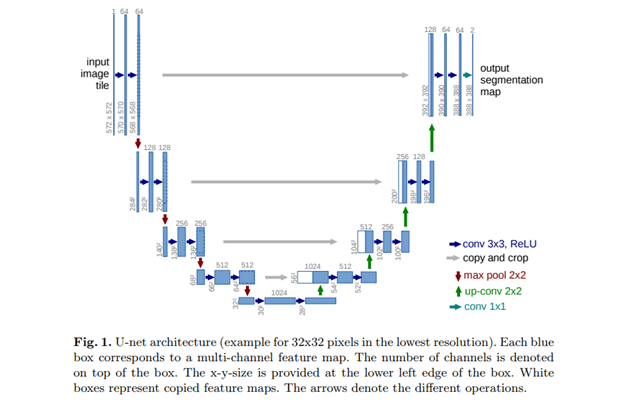

In [7]:
from pyplatypus.solvers.platypus_cv_solver import PlatypusSolver

ps = PlatypusSolver(
    config_yaml_path=Path("examples/data_science_bowl_config.yaml")
)
ps.train()

536 images detected!
Set 'steps_per_epoch' to: 34
134 images detected!
Set 'steps_per_epoch' to: 9
Training model:  ds_bowl_res_u_net


2022-11-20 12:33:52.965655: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 12:33:53.047288: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 12:33:53.048294: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-20 12:33:53.052471: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/100


2022-11-20 12:34:02.817746: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


34/34 [==============================] - 62s 2s/step - loss: 0.2107 - iou_coefficient: 0.4116 - categorical_crossentropy: 0.5654 - tversky_coefficient: 0.4822 - val_loss: 0.2571 - val_iou_coefficient: 0.3569 - val_categorical_crossentropy: 0.6528 - val_tversky_coefficient: 0.4252
Epoch 2/100
34/34 [==============================] - 45s 1s/step - loss: 0.1455 - iou_coefficient: 0.4892 - categorical_crossentropy: 0.4451 - tversky_coefficient: 0.5607 - val_loss: 0.1642 - val_iou_coefficient: 0.4787 - val_categorical_crossentropy: 0.4710 - val_tversky_coefficient: 0.5503
Epoch 3/100
34/34 [==============================] - 45s 1s/step - loss: 0.1091 - iou_coefficient: 0.5524 - categorical_crossentropy: 0.3660 - tversky_coefficient: 0.6218 - val_loss: 0.1632 - val_iou_coefficient: 0.5405 - val_categorical_crossentropy: 0.4224 - val_tversky_coefficient: 0.6104
Epoch 4/100
34/34 [==============================] - 45s 1s/step - loss: 0.0836 - iou_coefficient: 0.6136 - categorical_crossentropy:

Epoch 28/100
34/34 [==============================] - 48s 1s/step - loss: 0.0348 - iou_coefficient: 0.8349 - categorical_crossentropy: 0.1167 - tversky_coefficient: 0.8708 - val_loss: 0.0319 - val_iou_coefficient: 0.8417 - val_categorical_crossentropy: 0.1111 - val_tversky_coefficient: 0.8762
Epoch 29/100
34/34 [==============================] - 47s 1s/step - loss: 0.0327 - iou_coefficient: 0.8382 - categorical_crossentropy: 0.1126 - tversky_coefficient: 0.8735 - val_loss: 0.0299 - val_iou_coefficient: 0.8602 - val_categorical_crossentropy: 0.0994 - val_tversky_coefficient: 0.8911
Epoch 30/100
34/34 [==============================] - 47s 1s/step - loss: 0.0334 - iou_coefficient: 0.8401 - categorical_crossentropy: 0.1120 - tversky_coefficient: 0.8751 - val_loss: 0.0315 - val_iou_coefficient: 0.8596 - val_categorical_crossentropy: 0.1008 - val_tversky_coefficient: 0.8907
Epoch 31/100
34/34 [==============================] - 47s 1s/step - loss: 0.0330 - iou_coefficient: 0.8403 - categoric

Epoch 56/100
34/34 [==============================] - 47s 1s/step - loss: 0.0284 - iou_coefficient: 0.8641 - categorical_crossentropy: 0.0941 - tversky_coefficient: 0.8944 - val_loss: 0.0278 - val_iou_coefficient: 0.8747 - val_categorical_crossentropy: 0.0897 - val_tversky_coefficient: 0.9027
Epoch 57/100
34/34 [==============================] - 47s 1s/step - loss: 0.0281 - iou_coefficient: 0.8668 - categorical_crossentropy: 0.0923 - tversky_coefficient: 0.8966 - val_loss: 0.0282 - val_iou_coefficient: 0.8793 - val_categorical_crossentropy: 0.0873 - val_tversky_coefficient: 0.9064
Epoch 58/100
34/34 [==============================] - 47s 1s/step - loss: 0.0283 - iou_coefficient: 0.8674 - categorical_crossentropy: 0.0922 - tversky_coefficient: 0.8971 - val_loss: 0.0299 - val_iou_coefficient: 0.8671 - val_categorical_crossentropy: 0.0953 - val_tversky_coefficient: 0.8967
Epoch 59/100
34/34 [==============================] - 48s 1s/step - loss: 0.0285 - iou_coefficient: 0.8641 - categoric

Epoch 84/100
34/34 [==============================] - 48s 1s/step - loss: 0.0278 - iou_coefficient: 0.8751 - categorical_crossentropy: 0.0875 - tversky_coefficient: 0.9032 - val_loss: 0.0269 - val_iou_coefficient: 0.8713 - val_categorical_crossentropy: 0.0903 - val_tversky_coefficient: 0.9000
Epoch 85/100
34/34 [==============================] - 47s 1s/step - loss: 0.0268 - iou_coefficient: 0.8761 - categorical_crossentropy: 0.0860 - tversky_coefficient: 0.9040 - val_loss: 0.0267 - val_iou_coefficient: 0.8779 - val_categorical_crossentropy: 0.0866 - val_tversky_coefficient: 0.9053
Epoch 86/100
34/34 [==============================] - 47s 1s/step - loss: 0.0266 - iou_coefficient: 0.8740 - categorical_crossentropy: 0.0870 - tversky_coefficient: 0.9024 - val_loss: 0.0262 - val_iou_coefficient: 0.8955 - val_categorical_crossentropy: 0.0765 - val_tversky_coefficient: 0.9193
Epoch 87/100
34/34 [==============================] - 48s 1s/step - loss: 0.0269 - iou_coefficient: 0.8777 - categoric

Epoch 13/100
67/67 [==============================] - 43s 639ms/step - loss: 0.1097 - iou_coefficient: 0.8781 - categorical_crossentropy: 0.1097 - val_loss: 0.1755 - val_iou_coefficient: 0.7927 - val_categorical_crossentropy: 0.1755
Epoch 14/100
67/67 [==============================] - 44s 658ms/step - loss: 0.1119 - iou_coefficient: 0.8755 - categorical_crossentropy: 0.1119 - val_loss: 0.1026 - val_iou_coefficient: 0.8885 - val_categorical_crossentropy: 0.1026
Epoch 15/100
67/67 [==============================] - 44s 647ms/step - loss: 0.1056 - iou_coefficient: 0.8826 - categorical_crossentropy: 0.1056 - val_loss: 0.1124 - val_iou_coefficient: 0.8828 - val_categorical_crossentropy: 0.1124
Epoch 16/100
67/67 [==============================] - 43s 642ms/step - loss: 0.1073 - iou_coefficient: 0.8813 - categorical_crossentropy: 0.1073 - val_loss: 0.0992 - val_iou_coefficient: 0.8957 - val_categorical_crossentropy: 0.0992
Epoch 17/100
67/67 [==============================] - 43s 644ms/step

67/67 [==============================] - 49s 733ms/step - loss: 0.0691 - iou_coefficient: 0.9198 - categorical_crossentropy: 0.0691 - val_loss: 0.0654 - val_iou_coefficient: 0.9276 - val_categorical_crossentropy: 0.0654
Epoch 16/100
67/67 [==============================] - 49s 735ms/step - loss: 0.0689 - iou_coefficient: 0.9211 - categorical_crossentropy: 0.0689 - val_loss: 0.0644 - val_iou_coefficient: 0.9324 - val_categorical_crossentropy: 0.0644
Epoch 17/100
67/67 [==============================] - 50s 750ms/step - loss: 0.0680 - iou_coefficient: 0.9210 - categorical_crossentropy: 0.0680 - val_loss: 0.0639 - val_iou_coefficient: 0.9324 - val_categorical_crossentropy: 0.0639
Epoch 18/100
67/67 [==============================] - 50s 743ms/step - loss: 0.0683 - iou_coefficient: 0.9223 - categorical_crossentropy: 0.0683 - val_loss: 0.0643 - val_iou_coefficient: 0.9325 - val_categorical_crossentropy: 0.0643
Epoch 19/100
67/67 [==============================] - 50s 749ms/step - loss: 0.06

## Fine tuning and model loading with Platypus

After saving the models you may want to simply load them ar fine-tune them later. To do so you can add to each model and esnsmbler 2 extra parameters:

 - `fine_tuning_path` - path for the model weights you want to load
 - `fit` - boolean value that specifies if you want to trin the model or only create the architecture.

In [9]:
from pyplatypus.solvers.platypus_cv_solver import PlatypusSolver

ps = PlatypusSolver(
    config_yaml_path=Path("examples/data_science_bowl_config.yaml")
)
ps.train()

536 images detected!
Set 'steps_per_epoch' to: 34
134 images detected!
Set 'steps_per_epoch' to: 9
Training model:  ds_bowl_res_u_net
Weights loaded from examples/models/ds_bowl_res_u_net.hdf5
536 images detected!
Set 'steps_per_epoch' to: 67
134 images detected!
Set 'steps_per_epoch' to: 17
Training model:  ds_bowl_u_net_plus_plus
Weights loaded from examples/models/ds_bowl_u_net_plus_plus.hdf5
536 images detected!
Set 'steps_per_epoch' to: 67
134 images detected!
Set 'steps_per_epoch' to: 17
Training model:  ds_bowl_res_u_net_u_net_plus_plus_ensembler
Weights loaded from examples/models/ds_bowl_res_u_net_u_net_plus_plus_ensembler.hdf5


## Augmentation check
For the sake of sanity check, let's take a look at a sample of augmented images. It allows us to make sure that the augmentation effects are as we would expect.

In [10]:
augmented_images_res_u_net, augmented_images_u_net_plus_plus, augmented_images_res_u_net_u_net_plus_plus_ensembler = ps.sample_generators()

134 images detected!
Set 'steps_per_epoch' to: 9
134 images detected!
Set 'steps_per_epoch' to: 17
134 images detected!
Set 'steps_per_epoch' to: 17


Let's display five augmented images for each model.

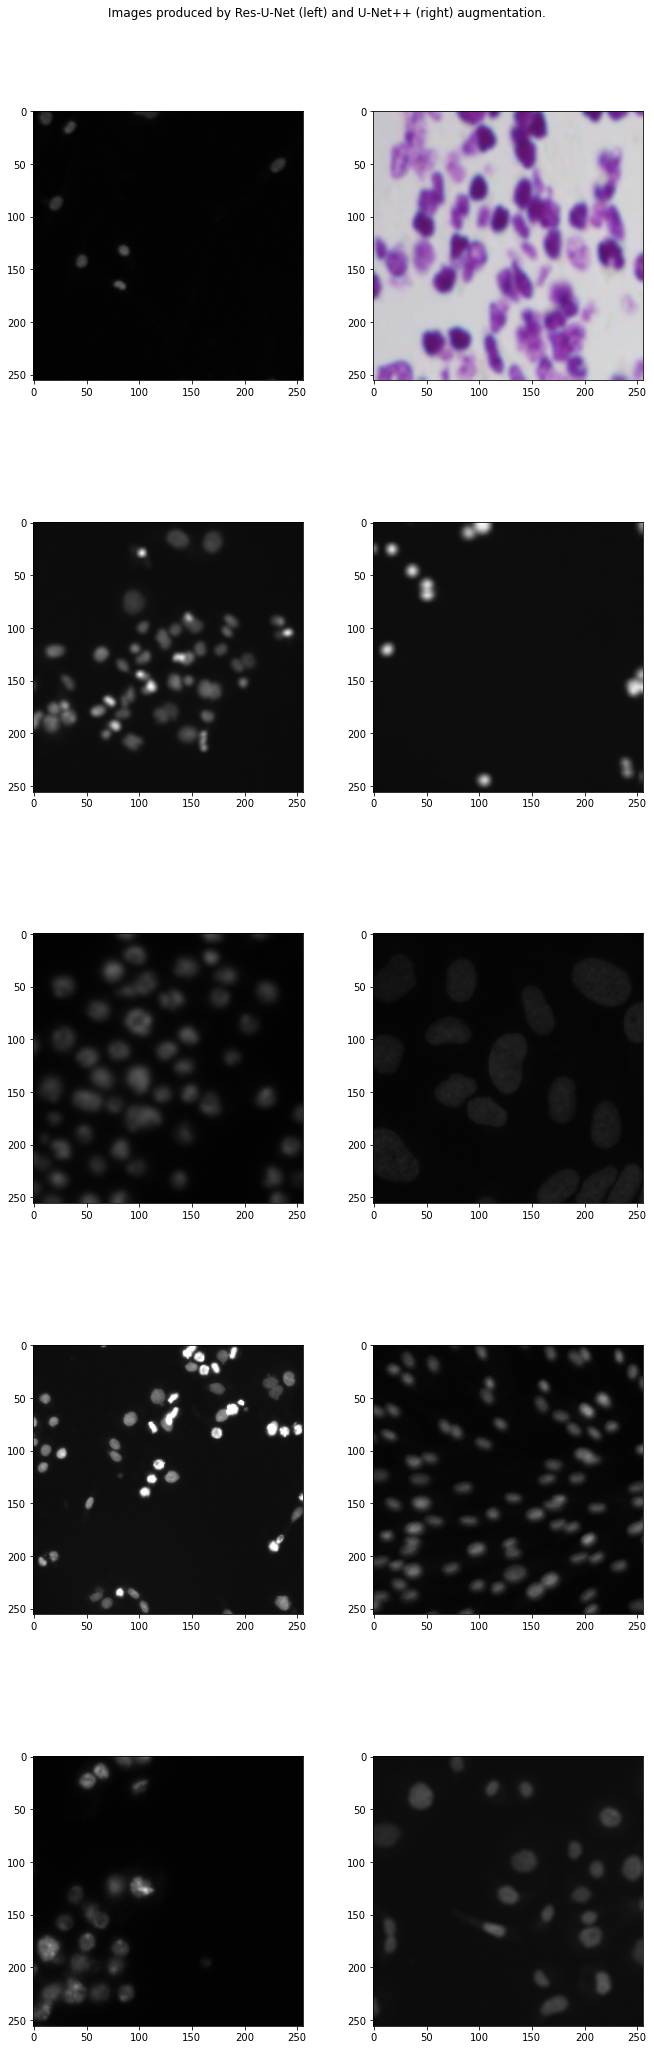

In [18]:
grid_length = 5
fig, axes = plt.subplots(grid_length, 2)
fig.suptitle("Images produced by Res-U-Net (left) and U-Net++ (right) augmentation.")
fig.set_size_inches(10, 30)
for aug1, aug2, i in zip(augmented_images_u_net_plus_plus[0][:grid_length], augmented_images_res_u_net[0][:grid_length], range(grid_length)):
    axes[(i, 0)].imshow(aug1)
    axes[(i, 1)].imshow(aug2)
fig.tight_layout(pad=4)

# Predictions

Only after do we train the models, we can easily produce predicted masks based on the validation set or whatever data that we would like to use, just make sure it is organized as in the train/validation/test sets.

In [19]:
# Clean the results of former runs
from glob import glob
from shutil import rmtree
masks = glob(str(data_path/"stage1_validation/**/predicted_*"))
for mask in masks:
    rmtree(mask)

### Models evaluation
Thanks to the evaluation-supporting methods of the PlatypusEngine, all created models may be quickly assesed.

In [20]:
metrics = ps.evaluate_models(task_type="semantic_segmentation")

134 images detected!
Set 'steps_per_epoch' to: 9
9/9 [==============================] - 9s 918ms/step - loss: 0.0254 - tversky_coefficient: 0.9134 - iou_coefficient: 0.8881 - categorical_crossentropy: 0.0798
134 images detected!
Set 'steps_per_epoch' to: 17
17/17 [==============================] - 8s 411ms/step - loss: 0.0764 - iou_coefficient: 0.9191 - categorical_crossentropy: 0.0764
134 images detected!
Set 'steps_per_epoch' to: 17
17/17 [==============================] - 12s 579ms/step - loss: 0.0629 - iou_coefficient: 0.9330 - categorical_crossentropy: 0.0629
EVALUATION RESULTS:

                                    model_name  focal_loss  \
0                            ds_bowl_res_u_net    0.025367   
0                      ds_bowl_u_net_plus_plus         NaN   
0  ds_bowl_res_u_net_u_net_plus_plus_ensembler         NaN   

   categorical_crossentropy  iou_coefficient  tversky_coefficient  cce_loss  
0                  0.913437         0.888104             0.079818       NaN  
0  

## Plotting the predictions
Now we could take a look at the predicted masks to assess if our model is learning proper goals. Maybe it does not infere the expected shape of objects? In such case loss function could be replaced, or the new, topology-powered one could be designed to tackle the task.

In [23]:
# When the custom_data_path is set to None, the validation data will be used.
# If that is not the intention of yours, feel free to point the engine to any other direction.
ps.produce_and_save_predicted_masks_for_model(model_name="ds_bowl_res_u_net", custom_data_path=None)

134 images detected!
Set 'steps_per_epoch' to: 9
1/1 [==============================] - 0s 20ms/step


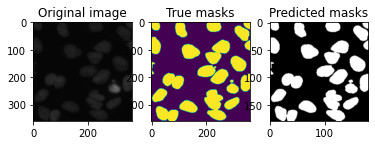

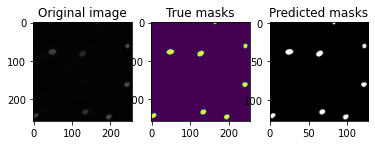

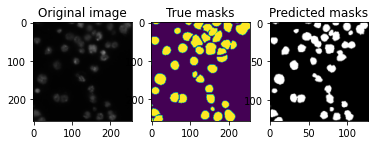

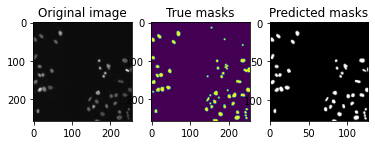

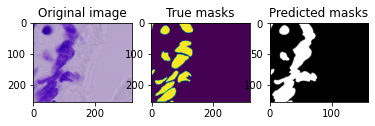

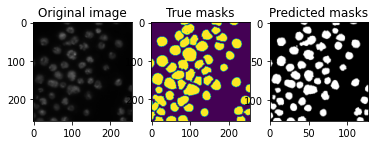

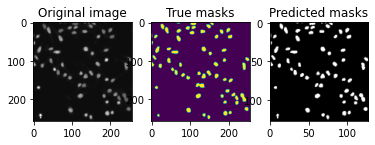

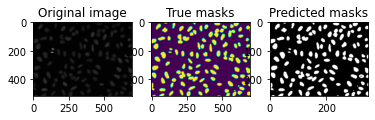

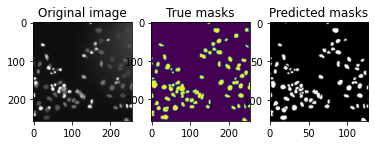

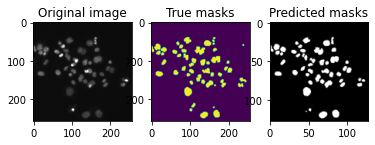

In [30]:
sample_and_plot_predictions(data_path, model_name="ds_bowl_res_u_net", n=10)

In [31]:
ps.produce_and_save_predicted_masks_for_model(model_name="ds_bowl_u_net_plus_plus", custom_data_path=None)

134 images detected!
Set 'steps_per_epoch' to: 17
1/1 [==============================] - 0s 23ms/step


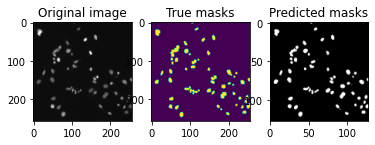

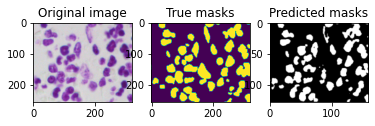

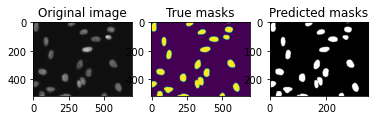

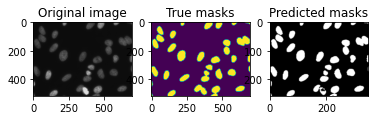

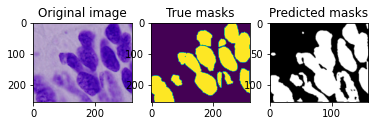

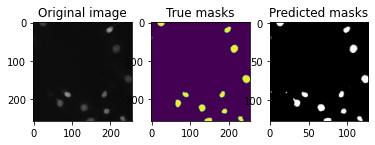

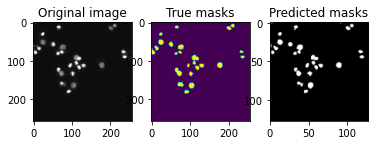

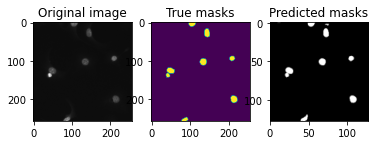

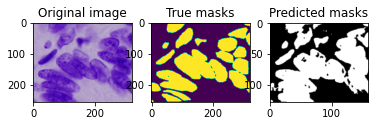

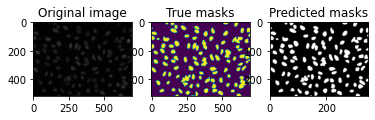

In [32]:
sample_and_plot_predictions(data_path, model_name="ds_bowl_u_net_plus_plus", n=10)

In [33]:
ps.produce_and_save_predicted_masks_for_model(model_name="ds_bowl_res_u_net_u_net_plus_plus_ensembler", custom_data_path=None)

134 images detected!
Set 'steps_per_epoch' to: 17
1/1 [==============================] - 0s 25ms/step


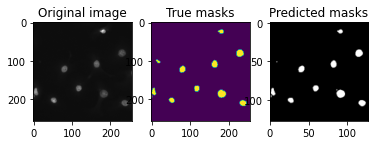

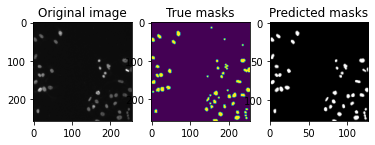

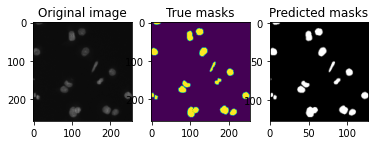

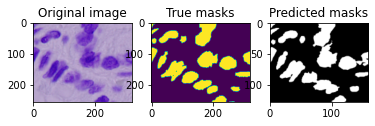

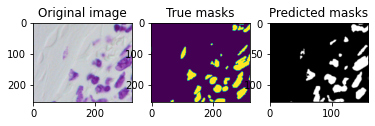

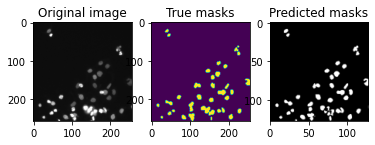

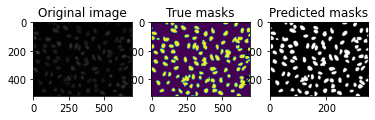

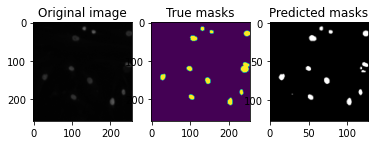

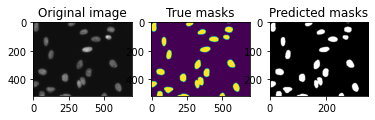

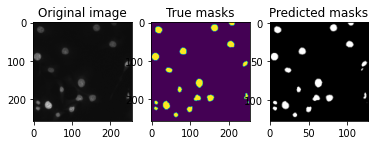

In [34]:
sample_and_plot_predictions(data_path, model_name="ds_bowl_res_u_net_u_net_plus_plus_ensembler", n=10)